## Polynomial Chaos Kriging with gstools

We start by defining a problem. Here we borrow the formulation from [uqlab](https://www.uqlab.com/pc-kriging-introduction).

In [1]:
import numpy
import chaospy

distribution = chaospy.Uniform(0, 15)
samples = distribution.sample(10, rule="sobol")
evaluations = samples*numpy.sin(samples)
evaluations.round(4)

array([  7.035 , -10.8878,  -2.1434,  -3.4407,   6.9566,   0.4665,
         1.7889,   0.909 ,  -7.9987,  14.0233])

The goal is to create a so called "polynomial chaos kriging" model as defined in [the paper with the same name](https://arxiv.org/abs/1502.03939). We are going to do this using the following steps:

* Create a pool of orthogonal polynomials using `chaospy`.
* Use `scikit-learn`'s least angular regression model to reduce the pool.
* Use `gstools` to create an universal Kriging model with the orthogonal polynomials as drift terms.

The result is what is what the paper defines as "sequential polynomial chaos kriging".

We start by creating a pool of orthonormal polynomials to be selected from:

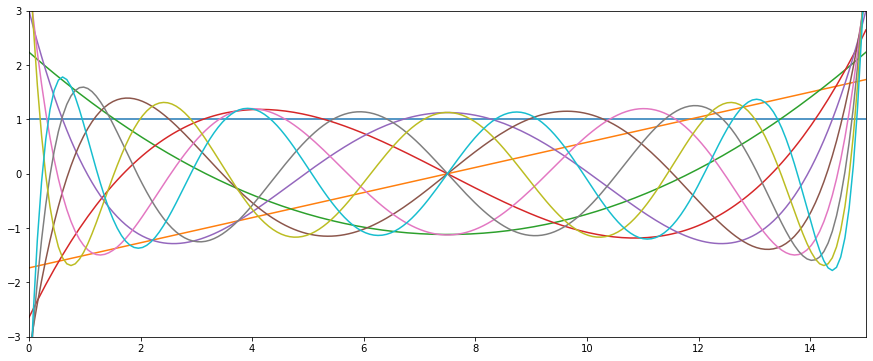

In [2]:
from matplotlib import pyplot

expansion = chaospy.generate_expansion(9, distribution, normed=True)

t = numpy.linspace(0, 15, 200)
pyplot.rc("figure", figsize=[15, 6])
pyplot.plot(t, expansion(t).T)
pyplot.axis([0, 15, -3, 3])
pyplot.show()

As `chaospy` does not support least angular regression, we use the [scikit-learn](https://scikit-learn.org/) implementation.
But still pass the job to `chaospy` to perform the fitting, as it also gives an fitted expansion:

In [3]:
# NBVAL_CHECK_OUTPUT
from sklearn.linear_model import LarsCV

lars = LarsCV(fit_intercept=False, max_iter=5)
pce, coeffs = chaospy.fit_regression(
    expansion, samples, evaluations, model=lars, retall=True)
expansion_ = expansion[coeffs != 0]

pce.round(2)

polynomial(0.01*q0**6-0.17*q0**5+1.42*q0**4-5.19*q0**3+5.89*q0**2+4.46*q0-5.32)

Note that the same coefficients can be created from the `lars` model directly, but that does not yield a fitted expansion:

In [4]:
# NBVAL_CHECK_OUTPUT
lars = LarsCV(fit_intercept=False, max_iter=5)
lars.fit(expansion(samples).T, evaluations)
expansion_ = expansion[lars.coef_ != 0]

lars.coef_.round(4)

array([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.5500e-01,  0.0000e+00,
       -1.1415e+00, -5.2567e+00, -2.9271e+00,  0.0000e+00,  4.2000e-03])

This resulted in a reduction of the number of polynomials:

In [5]:
print("number of expansion terms total:", len(expansion))
print("number of expansion terms included:", len(expansion_))

number of expansion terms total: 10
number of expansion terms included: 5


With the number of polynomials reduced, we can create our kriging model.
In this case we use the excellent [gstools](https://geostat-framework.readthedocs.io/) library:

In [6]:
import gstools

model = gstools.Gaussian(dim=1, var=1)
pck = gstools.krige.Universal(model, samples, evaluations, list(expansion_))

pck(samples)
assert numpy.allclose(pck.field, evaluations)

For reference, we also create a more traditional universal kriging model with linear drift.

In [7]:
uk = gstools.krige.Universal(model, samples, evaluations, "linear")
uk(samples)
assert numpy.allclose(uk.field, evaluations)

Lastly we visually compare the models by plotting the mean and standard deviations against each other:

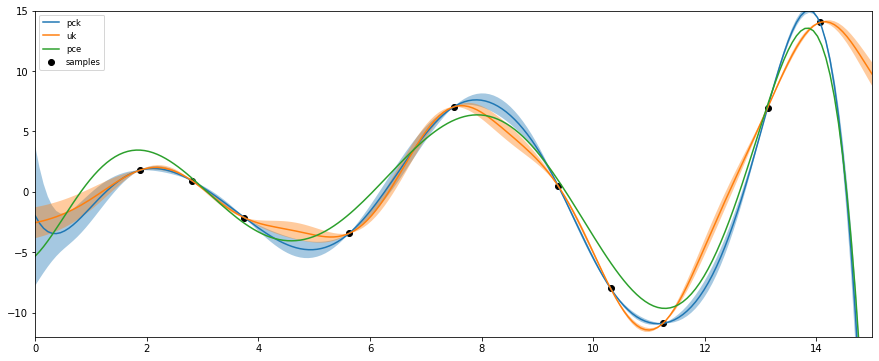

In [8]:
pck(t)
mu, sigma = pck.field, numpy.sqrt(pck.krige_var)
pyplot.plot(t, mu, label="pck")
pyplot.fill_between(t, mu-sigma, mu+sigma, alpha=0.4)

uk(t)
mu, sigma = uk.field, numpy.sqrt(uk.krige_var)
pyplot.plot(t, mu, label="uk")
pyplot.fill_between(t, mu-sigma, mu+sigma, alpha=0.4)

pyplot.plot(t, pce(t), label="pce")

pyplot.scatter(samples, evaluations, color="k", label="samples")

pyplot.axis([0, 15, -12, 15])
pyplot.legend(loc="upper left")
pyplot.show()